In [1]:
%config Completer.use_jedi = False

# Tesla AP analysis notebook

## Imports

In [9]:
import numpy as np
import pandas as pd
import os
import collections
import magic
import time
from scipy.signal import argrelextrema
from pathlib import Path 
import datetime
import matplotlib.pyplot as plt



%matplotlib inline

## Get data from mounted SQFS

In [3]:
dir_path = "/mnt/sqfs1" # Mount-point of the SquashFS

cnt_files = 0
cnt_dirs = 0

cnt_ext = collections.Counter() # Counter for file-types
cnt_brk_ext = 0

cnt_tsp = collections.Counter() # Counter for file time-stamps
cnt_brk_tsp = 0

for base, dirs, files in os.walk(dir_path):
    os.listdir(dir_path)
    for directory in dirs:
        cnt_dirs += 1
    for file in files:
        name, ext = os.path.splitext(file)
        cnt_ext[ext] += 1
        try:
            stat = os.stat(base + "/" + file)
            cnt_tsp[time.ctime(stat.st_mtime)] += 1
        except:
            cnt_brk_tsp += 1
            pass
        cnt_files += 1
        try:
            m_type = magic.from_file(base + "/" + file)
            # add to numpy array
        except:
            cnt_brk_ext += 1
            pass

print('Number of files:',cnt_files)
print('Number of directories:',cnt_dirs)
print('Total:',(cnt_files + cnt_dirs))
print('Number of broken files with non-valid type:', cnt_brk_ext)
print('Number of files with no time-stamp:', cnt_brk_tsp)

Number of files: 4216
Number of directories: 447
Total: 4663
Number of broken files with non-valid type: 291
Number of files with no time-stamp: 275


In [10]:
def collect_metadata(dict, path):
    """
    Collects metadata for a path and return the given dictionary.
    Currently get fullPath, lastAccessTime, lastModificationTime, lastChangeTime,
    and the type (file / directory).
    If for files, it also collects the fileSize.

    :param dict: dictionary where the metadata should be added to 
    :param path: path to the file or directory of interest
    :return: dictionary now containing the metadata 
    """

    dict['fullPath'] = os.path.abspath(path)

    last_atime = os.path.getatime(os.path.abspath(path))
    dict['lastAccessTime'] = str(datetime.datetime.fromtimestamp(last_atime))

    last_mtime = os.path.getmtime(os.path.abspath(path))
    dict['lastModificationTime'] = str(datetime.datetime.fromtimestamp(last_mtime))

    last_ctime = os.path.getctime(os.path.abspath(path))
    dict['lastChangeTime'] = str(datetime.datetime.fromtimestamp(last_ctime))
    
    if os.path.isdir(path):
        dict['type'] = "directory"
    else:
        dict['fileSize'] = os.path.getsize(os.path.abspath(path))
        dict['type'] = "file"

    return dict

def path_to_dict(path):
    d = {'name': os.path.basename(path)}
    if os.path.isdir(path):
        # This creates a PermissionError on the mount-point.
        #d['children'] = [path_to_dict(os.path.join(path,x)) for x in os.listdir(path)]

        # Collect different metadata.
        d = collect_metadata(d, path)
    else:
        # Collect different metadata.
        d = collect_metadata(d, path)
    return d

p_dict = path_to_dict(dir_path)
print(p_dict)

{'name': 'sqfs1', 'fullPath': '/mnt/sqfs1', 'lastAccessTime': '2019-07-19 06:40:58', 'lastModificationTime': '2019-07-19 06:40:58', 'lastChangeTime': '2019-07-19 06:40:58', 'type': 'directory'}


## Identified file-types

    file_type  count
139       .so    356
136        .0    221
5        .crt    140
137      .pem    133
4       .conf    103
178       .mo    100
180       .sl     46
140        .1     41
141        .2     33
2        .img     32
29        .sh     28
1        .txt     26
181      .map     26
182      .hlp     25
151      .bin     24
142        .4     19
153    .rules     18
163       .56     15
138     .hwdb     14
143        .6     14
147        .5     11
22        .10      9
183      .wav      9
159      .pdf      8
144        .3      7
133  .profile      7
165       .00      7
161       .13      6
167       .16      6


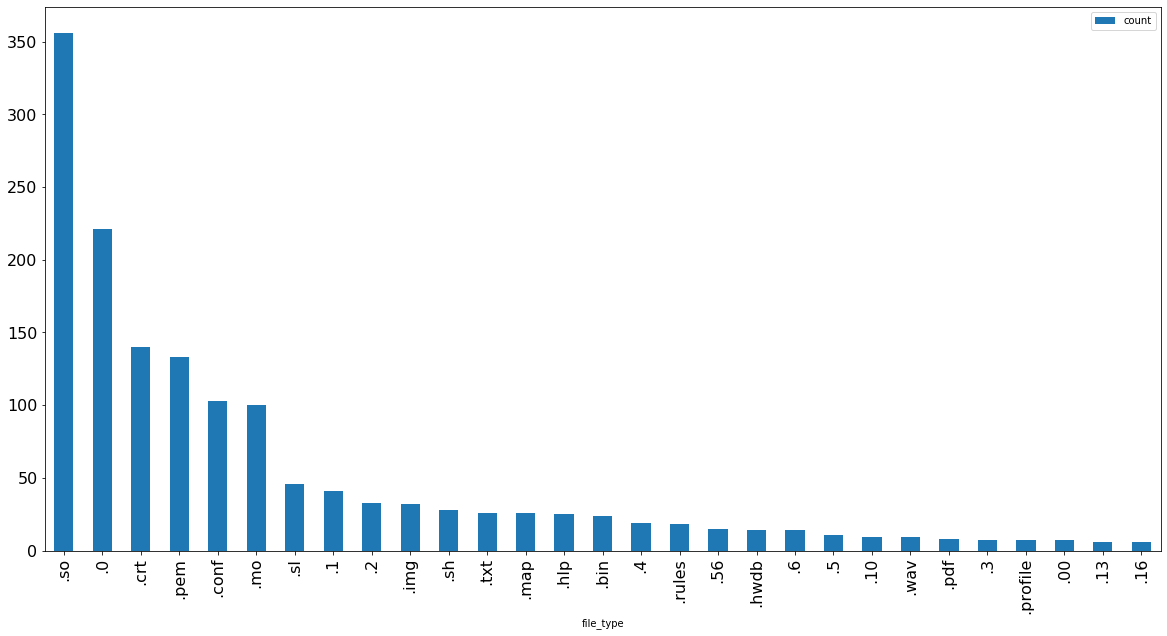

In [12]:
df_ftype = pd.DataFrame.from_dict(cnt_ext, orient='index').reset_index().sort_values(by=0, ascending=False).head(30)[1:]
df_ftype = df_ftype.rename(columns={'index':'file_type', 0:'count'})
print(df_ftype)

df_ftype.plot(x='file_type', y='count', kind='bar', figsize=(20, 10),fontsize=16)
plt.savefig('file-types.png')

Top dates:

Fri Jul 19 05:16:47 2019 1234
Fri Jul 19 05:51:13 2019  587
Fri Jul 19 05:51:12 2019  332
Fri Jul 19 05:28:04 2019  208
Fri Jul 19 05:28:03 2019  192
Fri Jul 19 05:51:06 2019  158
Fri Jul 19 05:23:04 2019  112
Fri Jul 19 05:51:18 2019  108
Fri Jul 19 05:29:59 2019  105
Fri Jul 19 04:22:50 2019   74


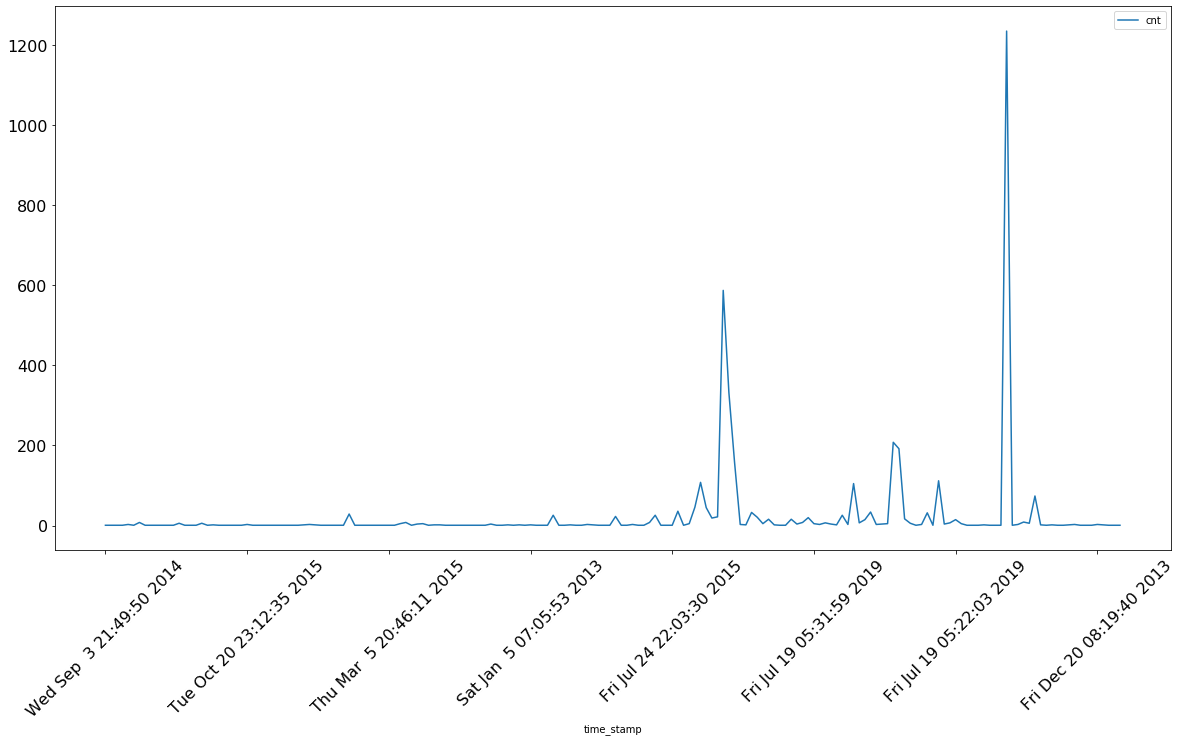

In [16]:
# Plot file time-stamps based on their count.
df_tsp_cnt = pd.DataFrame.from_dict(cnt_tsp, orient='index').reset_index().sort_values(by='index', ascending=False)
df_tsp_cnt = df_tsp_cnt.rename(columns={'index':'time_stamp', 0:'cnt'})
df_tsp_cnt.plot(x='time_stamp', y='cnt', kind='line', figsize=(20, 10), rot=45, fontsize=16)
plt.savefig('time-stamps.png')

# Sort dataframe bsed on their count and highlight top dates.
df_sort_cnt = pd.DataFrame.from_dict(cnt_tsp, orient='index').reset_index().sort_values(by=0, ascending=False)
df_sort_cnt = df_sort_cnt.rename(columns={'index':'time_stamp', 0:'cnt'})

print("Top dates:\n")
print(df_sort_cnt.head(10).to_string(index=False, header=False))